<a href="https://colab.research.google.com/github/Lmdela/Trabajo-de-Mineria-de-Datos/blob/Trabajo-Mineria/Redes_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes LSTM para la predicción de la temperatura del mar**

**Autores**
1. Antony D'Acunto, adacuntob@unal.edu.co
2. Luisa de la Hortúa, lmdela@unal.edu.co

**Fork**

**Referencias**
1.  https://calcofi.org/ccdata/database.html
5. https://new.data.calcofi.org/index.php/database/calcofi-database/bottle-field-descriptions
4. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
5. https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/


**Introducción** 

El conjunto de datos CalCOFI (California Cooperative Oceanic Fischers Investigations) representa la serie de datos oceanográficos y larvarios más larga desde 1949 hasta el presente y más completa (más de 50,000 estaciones de muestreo) del mundo. Incluye datos de abundancia sobre las larvas de más de 250 especies de peces; datos de frecuencia de longitud larval y datos de abundancia de huevos en especies comerciales clave; y datos oceanográficos y de plancton. Los datos físicos, químicos y biológicos recopilados a intervalos regulares de tiempo y espacio rápidamente se volvieron valiosos para documentar los ciclos climáticos en la corriente de California. La investigación de CalCOFI llamó la atención mundial sobre la respuesta biológica al dramático evento del calentamiento del Pacífico en 1957-58 e introdujo el término "El Niño" en la literatura científica.

---


**Planteamiento del problema**

El principal objetivo del problema, es la predicción del cambio de temperatura en el mar, apartir de datos recolectados en estaciones de muestreo. Entre los datos recolectados más importantes se encuentran la salinidad, la profundidad en la que es tomada la muestra y la densidad potencial del agua. Al ver que son datos tomados en el tiempo, que se presentan de una manera secuencial se decidio hacer uso de las redes LSTM, de esta manera hacer predicciones en el tiempo. 

**Metodología**
**Redes LSTM:** Son Redes Long Short Term Memory que se usan para el entendimeinto de predicciones que se hacen atraves de secuencias. Hacen parte de las redes neuronales, pero poseen una estructura más elaborada al momento de tratar la información nueva en cada paso. Como se muestra en el siguiente esquema.![texto alternativo](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
Estas redes tienen la habilidad de remover o añadir información a los estados de celdas. 


---



Para poder incorporar las variables de la salinidad del mar y densidad pontencial del agua se tienen que incorporar estas variables en una red LSTM multivariada. 

**Base de datos Bottles**

*   Depth_ID: [Century]-[YY][MM][ShipCode]-[CastType][Julian Day]-[CastTime]-[Line][Sta][Depth][Bottle]-[Rec_Ind]
*   T_degC: Temperatura del agua
*   Salnty: Salinidad del agua 
*   STheta: Densidad potencial del agua. 




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math 
import statistics as stat
import statsmodels.api as sm


%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
lowdata = pd.read_csv(r"low.csv", sep=(","), engine="python")
pd.set_option('display.max_rows', 10)
lowdata

,Year,Season,T_degC,Salnty,STheta
0,1949.0,2.0,14.742730,33.282691,24.669853
1,1949.0,3.0,16.879870,33.259035,24.166532
2,1949.0,4.0,15.908807,33.234647,24.372275
3,1950.0,1.0,33.354931,33.354931,33.354931
4,1950.0,2.0,13.984927,33.317026,24.863408
...,...,...,...,...,...
266,2015.0,4.0,18.385791,33.335460,23.885627
267,2016.0,1.0,33.337756,33.337756,33.337756
268,2016.0,2.0,16.367915,33.367942,24.374099
269,2016.0,3.0,17.436430,32.877884,23.703405


In [3]:
middata = pd.read_csv(r"mid.csv", sep=(","), engine="python")
pd.set_option('display.max_rows', 10)
middata

,Year,Season,T_degC,Salnty,STheta
0,1949.0,2.0,10.457389,33.548066,25.712890
1,1949.0,3.0,10.339411,33.531038,25.716322
2,1949.0,4.0,10.481904,33.497752,25.665846
3,1950.0,1.0,33.617823,33.617823,33.617823
4,1950.0,2.0,10.134502,33.635611,25.844010
...,...,...,...,...,...
266,2015.0,4.0,11.433827,33.489171,25.502124
267,2016.0,1.0,33.521852,33.521852,33.521852
268,2016.0,2.0,10.853380,33.611587,25.701475
269,2016.0,3.0,11.452516,33.540062,25.823412


In [4]:
highdata = pd.read_csv(r"high.csv", sep=(","), engine="python")
pd.set_option('display.max_rows', 10)
highdata

,Year,Season,T_degC,Salnty,STheta
0,1949.0,2.0,5.438834,34.258591,27.026743
1,1949.0,3.0,5.215942,34.282899,27.071624
2,1949.0,4.0,5.469926,34.252311,27.017963
3,1950.0,1.0,34.283299,34.283299,34.283299
4,1950.0,2.0,5.544914,34.299924,27.047712
...,...,...,...,...,...
266,2015.0,4.0,7.235226,34.177996,26.738663
267,2016.0,1.0,34.142393,34.142393,34.142393
268,2016.0,2.0,7.247855,34.163171,26.729759
269,2016.0,3.0,6.962514,34.174110,26.754887


In [12]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

rangee=lowdata.T_degC.isnull().sum()
for xxxx in range(rangee):
    # define input sequence
    stop=lowdata.T_degC.isnull().idxmax()
    # Prepare data
    series = lowdata.loc[0:stop-1]
    in_seq1 = series.T_degC.values
    in_seq2 = series.Salnty.values
    out_seq = series.STheta.values
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    dataset = hstack((in_seq1, in_seq2, out_seq))
    n_steps = 3
    X, y = split_sequences(dataset, n_steps)
    # the dataset knows the number of features, e.g. 2
    n_features = X.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=400, verbose=0)
    # demonstrate prediction
    x_input = lowdata[['T_degC','Salnty','STheta']].loc[stop-n_steps:stop-1].values
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    lowdata.T_degC[stop]=yhat[0,0]
    lowdata.Salnty[stop]=yhat[0,1]
    lowdata.STheta[stop]=yhat[0,2]
rangee=middata.T_degC.isnull().sum()
for xxxx in range(rangee):
    #Middata
    # define input sequence
    stop=middata.T_degC.isnull().idxmax()
    # Prepare data
    series = middata.loc[0:stop-1]
    in_seq1 = series.T_degC.values
    in_seq2 = series.Salnty.values
    out_seq = series.STheta.values
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    dataset = hstack((in_seq1, in_seq2, out_seq))
    n_steps = 3
    X, y = split_sequences(dataset, n_steps)
    # the dataset knows the number of features, e.g. 2
    n_features = X.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=400, verbose=0)
    # demonstrate prediction
    x_input = middata[['T_degC','Salnty','STheta']].loc[stop-n_steps:stop-1].values
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    middata.T_degC[stop]=yhat[0,0]
    middata.Salnty[stop]=yhat[0,1]
    middata.STheta[stop]=yhat[0,2]
    #Highdata
rangee=highdata.T_degC.isnull().sum()
for xxxx in range(rangee):
    #define input sequence
    stop=highdata.T_degC.isnull().idxmax()
    # Prepare data
    series = highdata.loc[0:stop-1]
    in_seq1 = series.T_degC.values
    in_seq2 = series.Salnty.values
    out_seq = series.STheta.values
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    dataset = hstack((in_seq1, in_seq2, out_seq))
    n_steps = 3
    X, y = split_sequences(dataset, n_steps)
    # the dataset knows the number of features, e.g. 2
    n_features = X.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=400, verbose=0)
    # demonstrate prediction
    x_input = highdata[['T_degC','Salnty','STheta']].loc[stop-n_steps:stop-1].values
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    highdata.T_degC[stop]=yhat[0,0]
    highdata.Salnty[stop]=yhat[0,1]
    highdata.STheta[stop]=yhat[0,2]
    print(xxxx+1,"/",rangee)
    


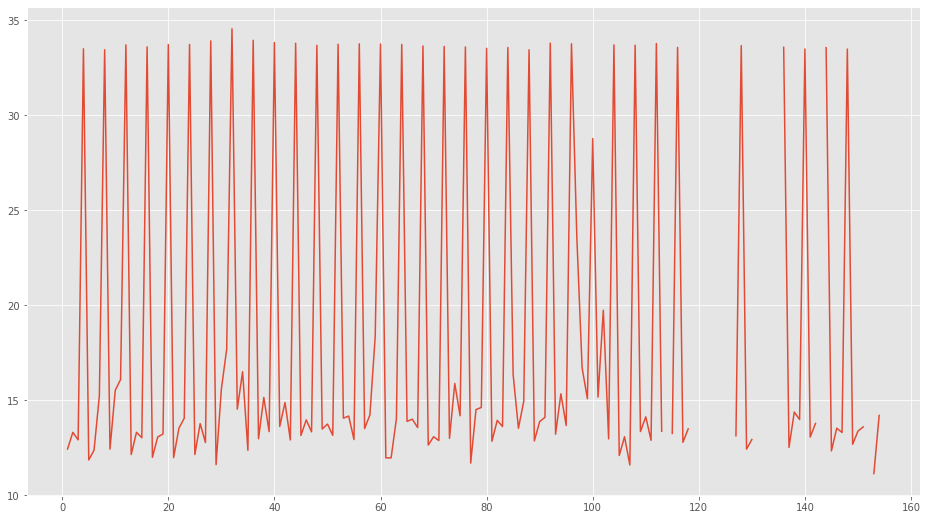

In [ ]:
plt.plot (lowdata.T_degC)